Original Data Shape: (9471, 13)

Missing Values Count:
CO(GT): 1797 missing values (18.97%)
PT08.S1(CO): 480 missing values (5.07%)
NMHC(GT): 8557 missing values (90.35%)
C6H6(GT): 480 missing values (5.07%)
PT08.S2(NMHC): 480 missing values (5.07%)
NOx(GT): 1753 missing values (18.51%)
PT08.S3(NOx): 480 missing values (5.07%)
NO2(GT): 1756 missing values (18.54%)
PT08.S4(NO2): 480 missing values (5.07%)
PT08.S5(O3): 480 missing values (5.07%)
T: 480 missing values (5.07%)
RH: 480 missing values (5.07%)
AH: 480 missing values (5.07%)


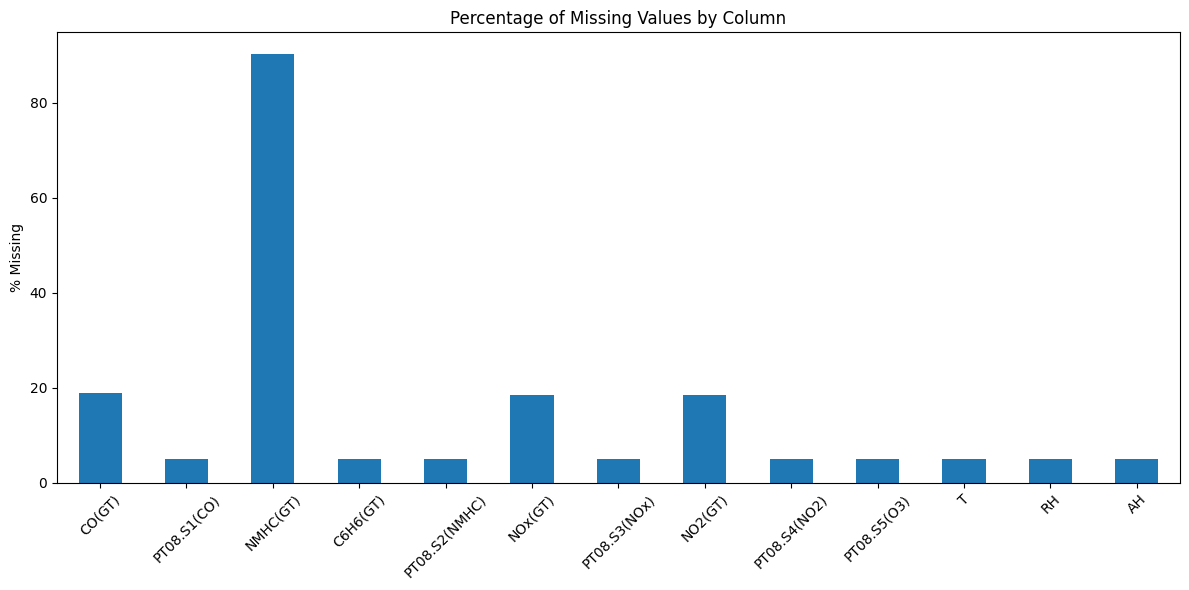


Correlation Matrix (Numeric Form):
               CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH    AH
CO(GT)           1.00         0.88      0.89      0.93           0.92     0.80         -0.70     0.68          0.63         0.85  0.02  0.05  0.05
PT08.S1(CO)      0.88         1.00      0.79      0.88           0.89     0.71         -0.77     0.64          0.68         0.90  0.05  0.11  0.14
NMHC(GT)         0.89         0.79      1.00      0.90           0.88     0.81         -0.77     0.73          0.85         0.77  0.39 -0.19  0.27
C6H6(GT)         0.93         0.88      0.90      1.00           0.98     0.72         -0.74     0.61          0.77         0.87  0.20 -0.06  0.17
PT08.S2(NMHC)    0.92         0.89      0.88      0.98           1.00     0.70         -0.80     0.65          0.78         0.88  0.24 -0.09  0.19
NOx(GT)          0.80         0.71      0.81      0.72           0.70     1.00    

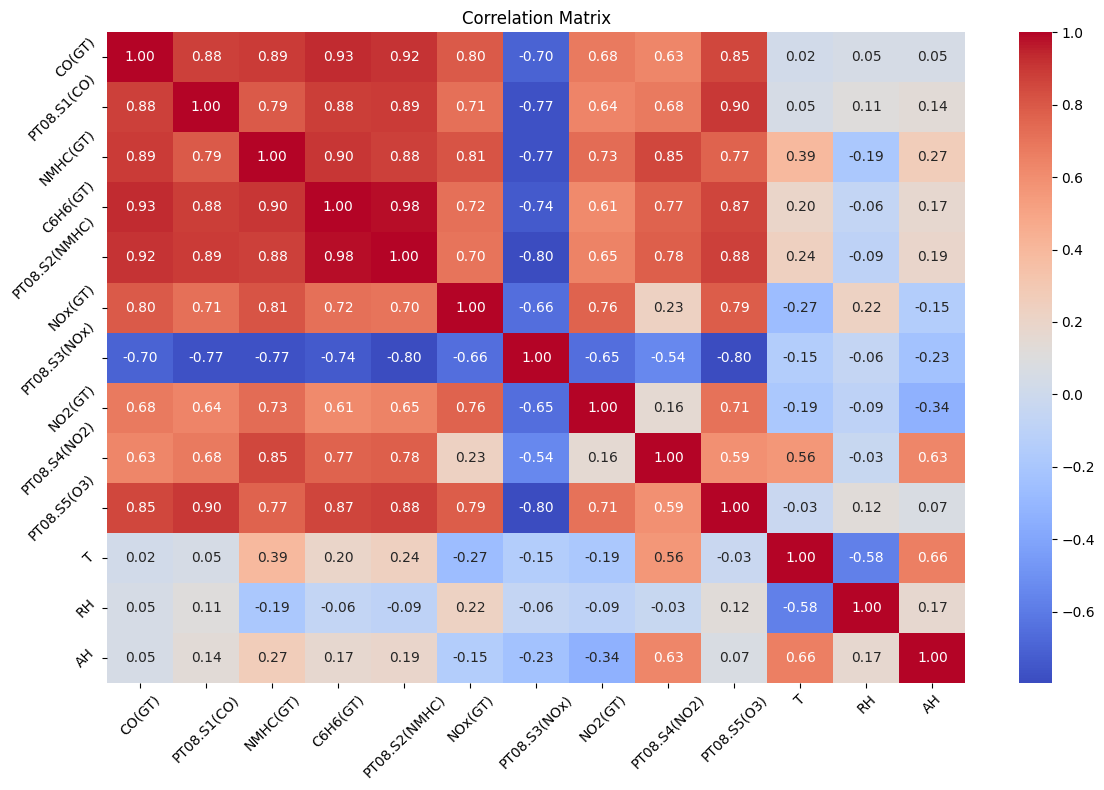

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read and preprocess data with correct separator
df = pd.read_csv('AirQualityUCI.csv', sep=';')

# Remove unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Convert commas to dots in numeric columns and convert to float
for column in df.columns:
    if column not in ['Date', 'Time']:
        # Check if the column is object (string) type
        if df[column].dtype == 'object':
            df[column] = df[column].str.replace(',', '.').astype(float)
        else:
            df[column] = df[column].astype(float)

# Convert -200 to NaN
df = df.replace(-200, np.nan)

# Drop Date and Time columns
df = df.drop(['Date', 'Time'], axis=1)

# Store original data for comparison
df_original = df.copy()

# Initial information
print("Original Data Shape:", df.shape)
print("\nMissing Values Count:")
for column in df.columns:
    missing = df[column].isnull().sum()
    if missing > 0:
        print(f"{column}: {missing} missing values ({missing/len(df)*100:.2f}%)")

# Missing values percentage bar plot
plt.figure(figsize=(12, 6))
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values by Column')
plt.xticks(rotation=45)
plt.ylabel('% Missing')
plt.tight_layout()
plt.show()

# Correlation heatmap of numeric columns
plt.figure(figsize=(12, 8))
correlation = df.corr()

# Print the correlation matrix in numeric form
print("\nCorrelation Matrix (Numeric Form):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)
print(correlation)

# Visualize the correlation matrix as a heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
print(df.head())

   CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH    AH
0     2.6       1360.0     150.0      11.9         1046.0    166.0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.76
1     2.0       1292.0     112.0       9.4          955.0    103.0        1174.0     92.0        1559.0        972.0  13.3  47.7  0.73
2     2.2       1402.0      88.0       9.0          939.0    131.0        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.75
3     2.2       1376.0      80.0       9.2          948.0    172.0        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.79
4     1.6       1272.0      51.0       6.5          836.0    131.0        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.79


In [11]:
def EM_step(data, columns, corr_matrix):
    imputed_data = data.copy()
    
    # Iterate over columns with missing values
    for col in columns:
        missing_mask = imputed_data[col].isnull()
        # If the column has missing values
        if missing_mask.sum() > 0:
            correlations = corr_matrix[col].abs()
            correlations = correlations[correlations.index != col]
            best_predictor = correlations.idxmax()
            
            # If the best predictor has a correlation greater than 0.3
            if correlations[best_predictor] > 0.3:
                # Select rows where both the column and the best predictor are not missing
                valid_mask = ~data[col].isnull() & ~data[best_predictor].isnull()
                x = data.loc[valid_mask, best_predictor]
                y = data.loc[valid_mask, col]
                
                # Compute the linear regression coefficients
                beta = np.cov(x, y)[0,1] / np.var(x)
                alpha = y.mean() - beta * x.mean()
                
                # Predict the missing values using the linear regression model
                pred = alpha + beta * data.loc[missing_mask, best_predictor]
                # Add noise to the prediction to avoid overfitting
                noise = np.random.normal(0, y.std() * 0.1, size=len(pred))
                # Replace the missing values with the predictions
                imputed_data.loc[missing_mask, col] = pred + noise
            else:
                # If the correlation is less than 0.3, impute the missing values with the mean
                mean_val = data[col].mean()
                std_val = data[col].std()
                noise = np.random.normal(0, std_val * 0.1, size=missing_mask.sum())
                imputed_data.loc[missing_mask, col] = mean_val + noise
    
    return imputed_data

# Perform EM imputation
numeric_columns = df.select_dtypes(include=[np.number]).columns
np.random.seed(42)  

# Iterative imputation
max_iterations = 10
for iteration in range(max_iterations):
    correlation_matrix = df.corr()

    # Perform the EM step
    new_data = EM_step(df, numeric_columns, correlation_matrix)
    
    # Check for convergence
    if np.allclose(df.fillna(0), new_data.fillna(0), rtol=1e-3):
        print(f"Converged after {iteration + 1} iterations")
        break
    df = new_data

# Store the imputed dataset
imputed_df = df.copy()

Converged after 5 iterations


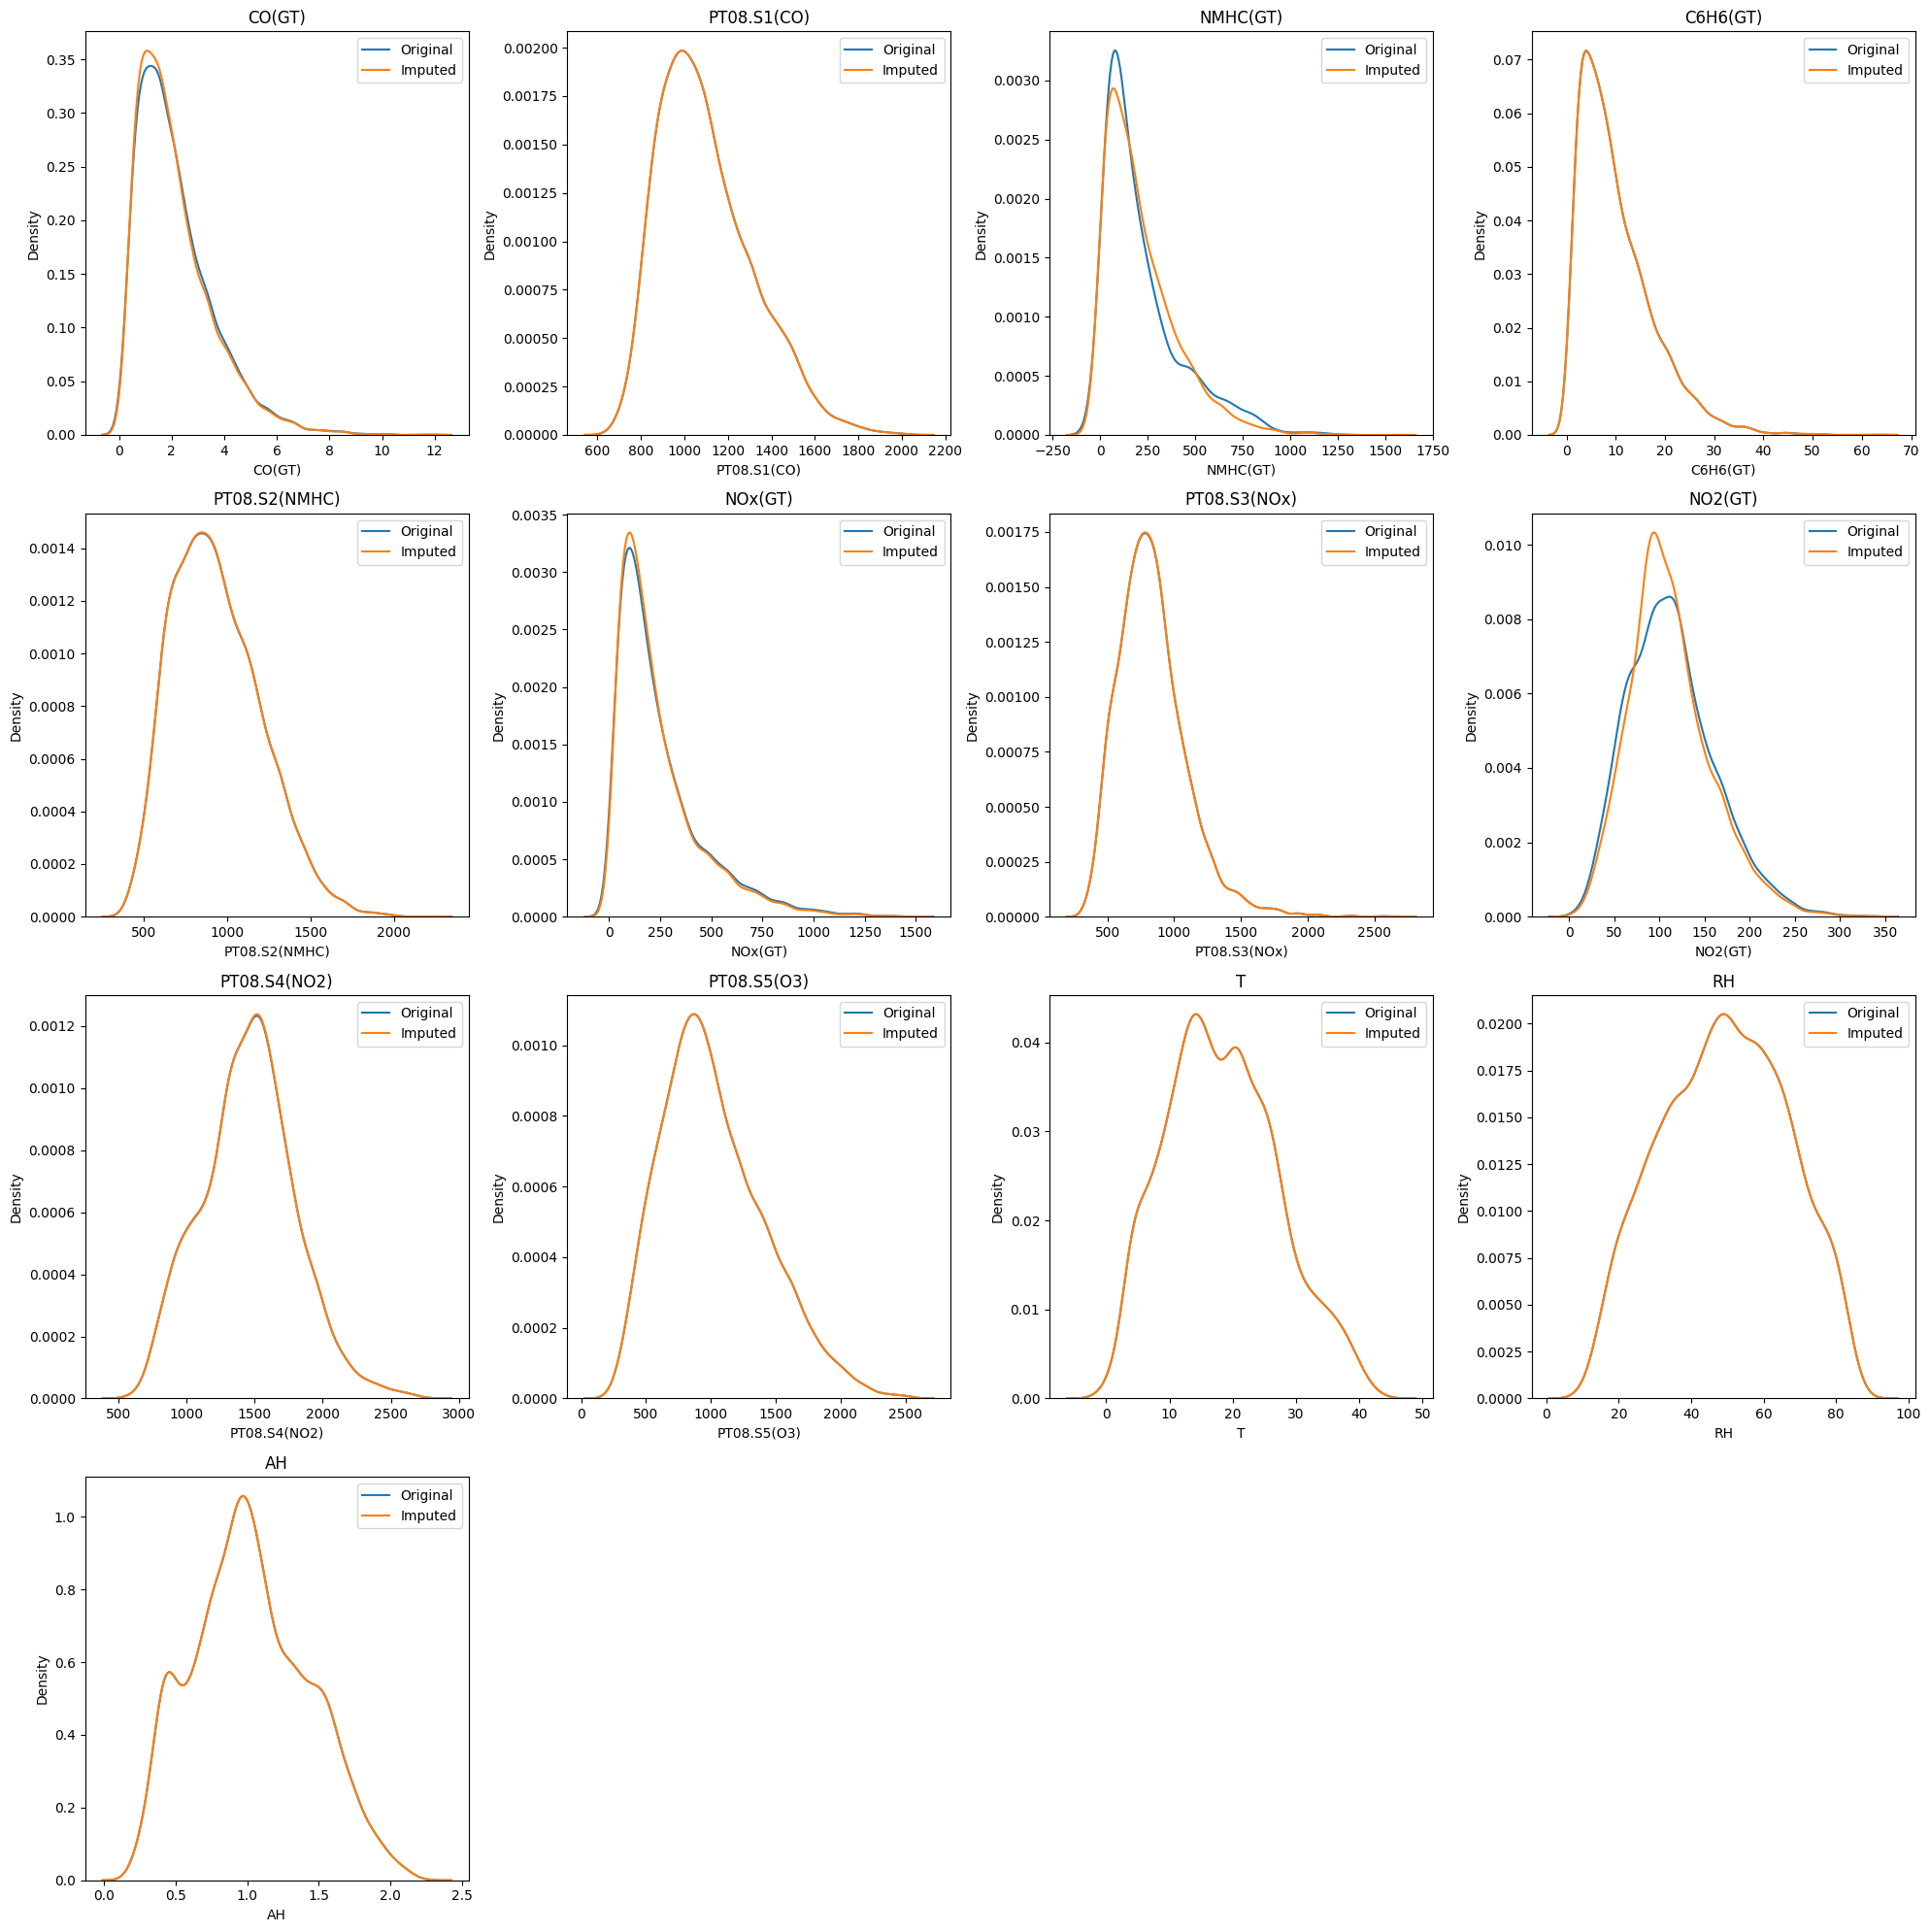

In [12]:
# Get all numeric columns
numeric_columns = df_original.select_dtypes(include=[np.number]).columns
n_cols = 4  
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  

# Plot distributions before and after imputation for all numeric variables
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.ravel()  # Flatten the axes array for easy iteration

for idx, var in enumerate(numeric_columns):
    sns.kdeplot(data=df_original[var].dropna(), ax=axes[idx], label="Original")
    sns.kdeplot(data=imputed_df[var], ax=axes[idx], label="Imputed")
    axes[idx].set_title(var)
    axes[idx].legend()

# Remove empty subplots
for idx in range(len(numeric_columns), n_rows * n_cols):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [13]:
# Compare summary statistics for all numeric variables
print("Original Data Summary:")
print(df_original[numeric_columns].describe().round(2))

print("\nImputed Data Summary:")
print(imputed_df[numeric_columns].describe().round(2))

Original Data Summary:
        CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)        T       RH       AH
count  7674.00      8991.00    914.00   8991.00        8991.00  7718.00       8991.00  7715.00       8991.00      8991.00  8991.00  8991.00  8991.00
mean      2.15      1099.83    218.81     10.08         939.15   246.90        835.49   113.09       1456.26      1022.91    18.32    49.23     1.03
std       1.45       217.08    204.46      7.45         266.83   212.98        256.82    48.37        346.21       398.48     8.83    17.32     0.40
min       0.10       647.00      7.00      0.10         383.00     2.00        322.00     2.00        551.00       221.00    -1.90     9.20     0.18
25%       1.10       937.00     67.00      4.40         734.50    98.00        658.00    78.00       1227.00       731.50    11.80    35.80     0.74
50%       1.80      1063.00    150.00      8.20         909.00   180.00        806.

Original Data Correlation Matrix:
               CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH    AH
CO(GT)           1.00         0.88      0.89      0.93           0.92     0.80         -0.70     0.68          0.63         0.85  0.02  0.05  0.05
PT08.S1(CO)      0.88         1.00      0.79      0.88           0.89     0.71         -0.77     0.64          0.68         0.90  0.05  0.11  0.14
NMHC(GT)         0.89         0.79      1.00      0.90           0.88     0.81         -0.77     0.73          0.85         0.77  0.39 -0.19  0.27
C6H6(GT)         0.93         0.88      0.90      1.00           0.98     0.72         -0.74     0.61          0.77         0.87  0.20 -0.06  0.17
PT08.S2(NMHC)    0.92         0.89      0.88      0.98           1.00     0.70         -0.80     0.65          0.78         0.88  0.24 -0.09  0.19
NOx(GT)          0.80         0.71      0.81      0.72           0.70     1.00      

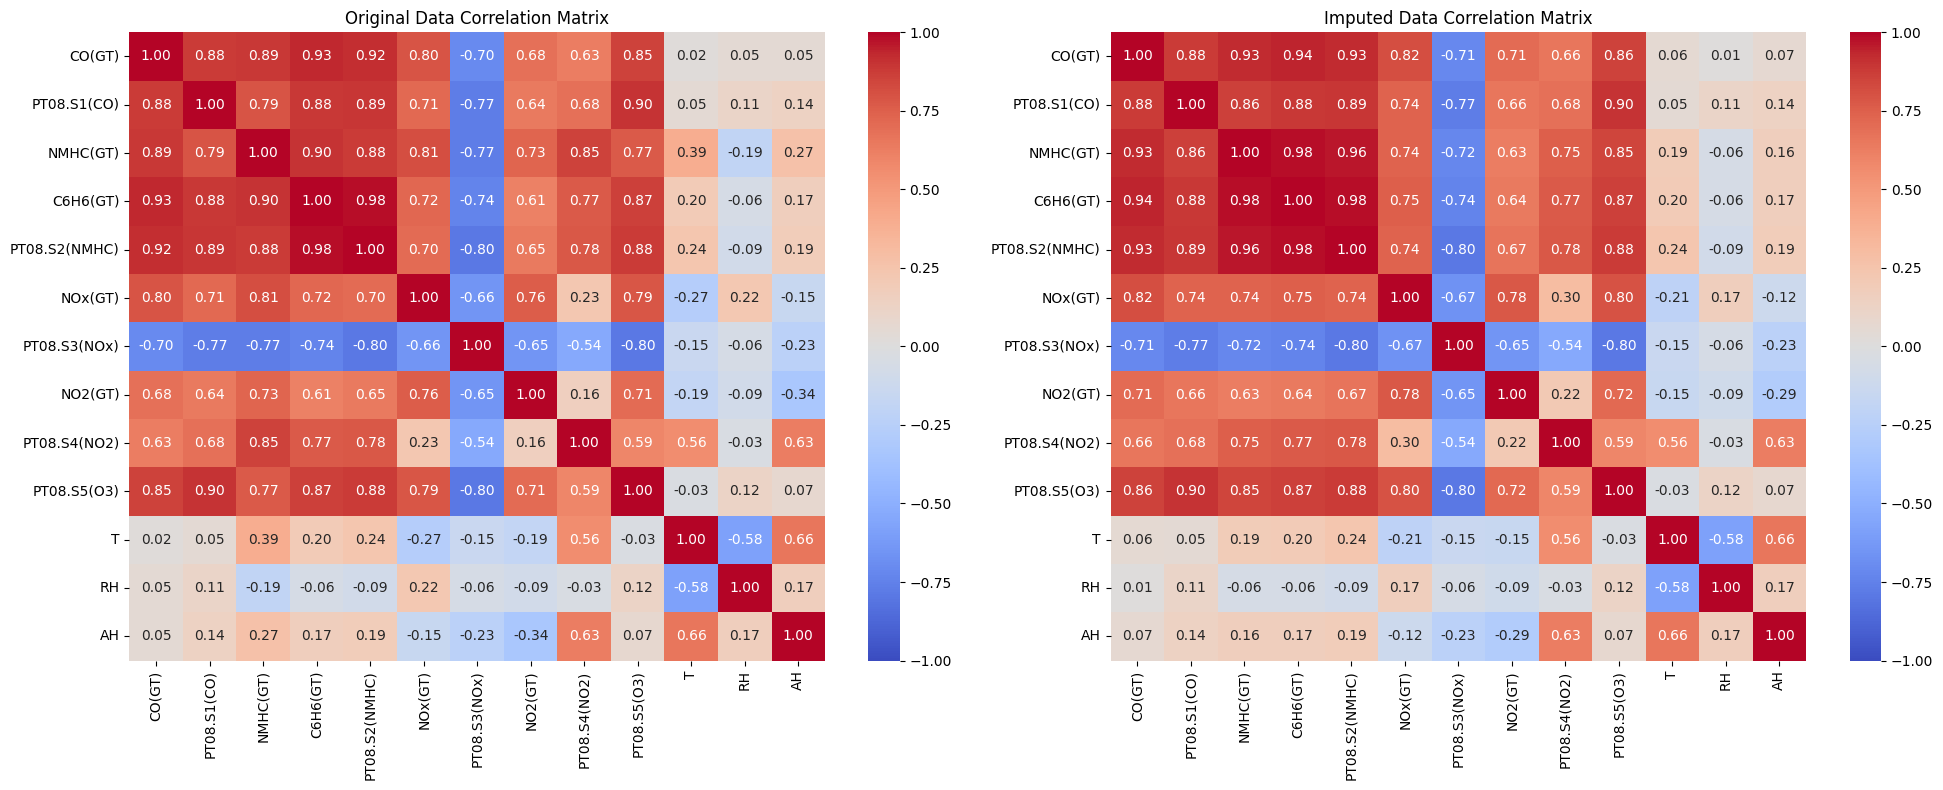


Maximum correlation difference: 0.1968700200163805
Average correlation difference: 0.022234892316529784


In [14]:
# Compute correlation matrices
original_corr = df_original.corr()
imputed_corr = imputed_df.corr()

# Print the correlation matrices in text form
print("Original Data Correlation Matrix:")
print(original_corr.round(2))  # Round to 2 decimal places for readability

print("\nImputed Data Correlation Matrix:")
print(imputed_corr.round(2))  # Round to 2 decimal places for readability

# Plot correlation matrices
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.heatmap(original_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Original Data Correlation Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(imputed_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Imputed Data Correlation Matrix")

plt.tight_layout()
plt.show()

# Calculate and print differences in correlations
diff = np.abs(original_corr - imputed_corr)
print("\nMaximum correlation difference:", diff.max().max())
print("Average correlation difference:", diff.mean().mean())

Correlation Difference Matrix:
               CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH    AH
CO(GT)           0.00         0.00      0.04      0.01           0.01     0.02          0.01     0.03          0.03         0.00  0.04  0.04  0.02
PT08.S1(CO)      0.00         0.00      0.07      0.00           0.00     0.02          0.00     0.02          0.00         0.00  0.00  0.00  0.00
NMHC(GT)         0.04         0.07      0.00      0.08           0.09     0.07          0.05     0.10          0.10         0.08  0.20  0.13  0.11
C6H6(GT)         0.01         0.00      0.08      0.00           0.00     0.03          0.00     0.03          0.00         0.00  0.00  0.00  0.00
PT08.S2(NMHC)    0.01         0.00      0.09      0.00           0.00     0.03          0.00     0.02          0.00         0.00  0.00  0.00  0.00
NOx(GT)          0.02         0.02      0.07      0.03           0.03     0.00         

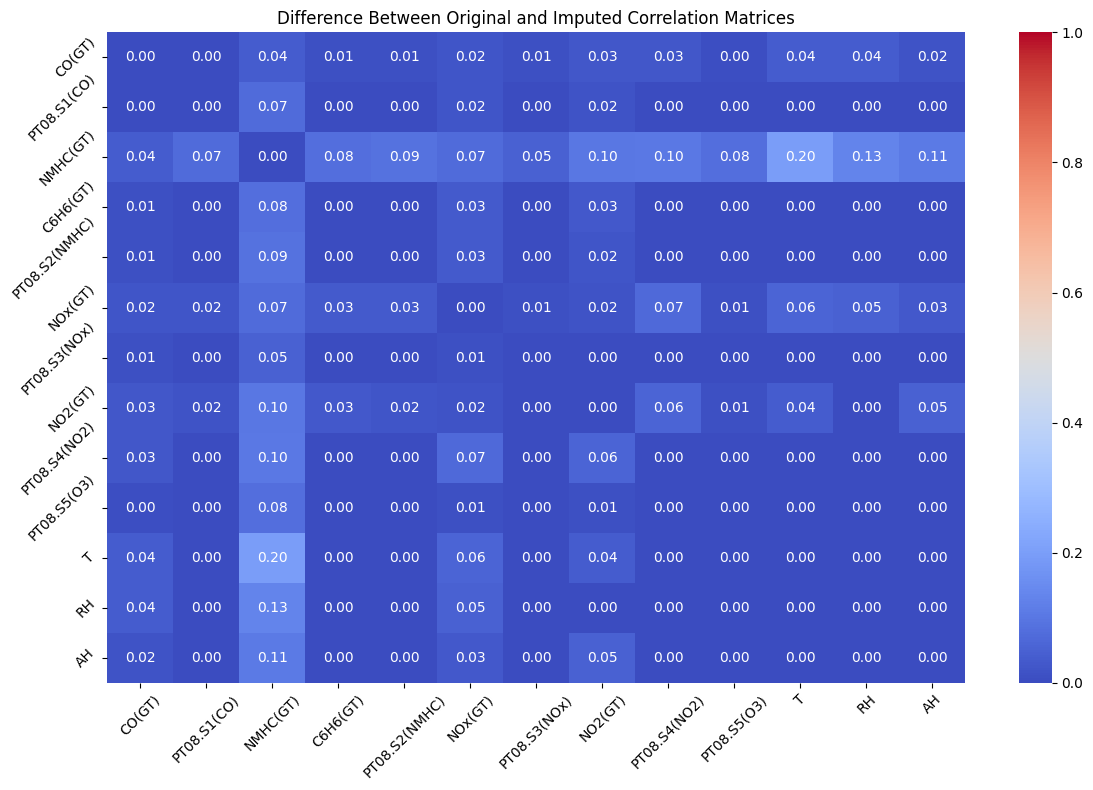

In [15]:
# Compute the difference between correlation matrices
corr_diff = np.abs(original_corr - imputed_corr)

# Print the difference matrix
print("Correlation Difference Matrix:")
print(corr_diff.round(2))

# Plot the difference matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_diff, annot=True, cmap="coolwarm", fmt=".2f", vmin=0, vmax=1)
plt.title("Difference Between Original and Imputed Correlation Matrices")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()